In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin,cos
from scipy.integrate import solve_ivp
from hurst import compute_Hc
import pandas as pd
from nolds import hurst_rs
import statsmodels.graphics.tsaplots as sgt

#  Paramater Sweep Heat Map

### Define system constants:

In [2]:
omega = 1
Lambda = 1

### Define system DEs as function:

In [3]:
def quantum_model(t, x):  
  #  if (x[1]>1*Lambda):
   #     x[1] = 0.5*Lambda
        
    return [
        -omega*Lambda* (x[0]*x[2])**0.5 *cos(x[3])*(sin(x[1])),  # d(I_e)/dt
        omega -0.5*omega*Lambda* (x[2]/x[0])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_e)/dt
        2*omega*x[4]*Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3])),  # d(I_m)/dt
        omega*x[4]*Lambda* (x[0]/x[2])**0.5 *(cos(x[3])*cos(x[1])),  # d(phi_m)/dt
        -Lambda* (x[0]*x[2])**0.5 *(cos(x[1])*sin(x[3]))  # d(n)/dt
    ]

### Define time range and initial conditions:

In [4]:
dt = 0.01
t_test = np.arange(0,300,dt)
X0 = [0.5, 0.5, 0.5, 0.5, 1]

### Solve our equations using solve_ivp

In [5]:
sol = solve_ivp(quantum_model, (t_test[0], t_test[-1]), X0, method='BDF', t_eval=t_test) # Integrate
x_test = np.transpose(sol.y)

### Plot:

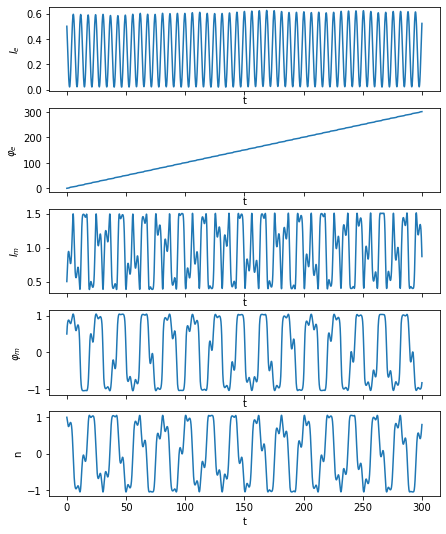

In [6]:
fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7,9))
plt.rc('axes', labelsize=15)
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_test[:, i])
    axs[i].set(xlabel='t', ylabel=['$I_e$','$\u03C6_e$','$I_m$','$\u03C6_m$', 'n'][i])


## Using Hurst package

In [7]:
H1 = np.zeros(5)

for i in range(5):
    H1[i] = compute_Hc(x_test[:,i])[0]

## Using Python-Forum IO code

In [8]:
def custom_hurst(series):
    #series = series.tail(365)
    max_window = len(series)
    min_window = 15
     

     
    def to_inc(x):
        incs = x[1:] - x[:-1]
        return incs
     
    def to_pct(x):
        pcts = x[1:] / x[:-1] - 1.
        return pcts
     
    def RS_func(series):
        incs = to_pct(series)
        mean_inc = np.sum(incs) / len(incs)
        deviations = incs - mean_inc
        Z = np.cumsum(deviations)
        R = max(Z) - min(Z)
        S = np.std(incs, ddof=1)
        return R / S
     
     
    err = np.geterr()
    np.seterr(all='raise')
     
    max_window = max_window or len(series)-1
    window_sizes = [15,30,45,90,182,365]
     
    RS = []
     
    for w in window_sizes:
            rs = []
            for start in range(0, len(series), w):
                if (start+w)>len(series):
                    break
                _ = RS_func(series[start:start+w])
                if _ != 0:
                    rs.append(_)
            RS.append(np.mean(rs))
     
    A = np.vstack([np.log10(window_sizes), np.ones(len(RS))]).T
    H, c = np.linalg.lstsq(A, np.log10(RS), rcond=-1)[0]
    np.seterr(**err)
     
    c = 10**c
 
    return H

In [9]:
H2 = np.zeros(5)

for i in range(5):
    H2[i] = custom_hurst(x_test[:,i])

## Using GenHurst GitHub code

In [10]:
import warnings
 
def genhurst(S,q):

    L=len(S)       
    if L < 100:
        warnings.warn('Data series very short!')
       
    H = np.zeros((len(range(5,20)),1))
    k = 0
    
    for Tmax in range(5,20):
        
        x = np.arange(1,Tmax+1,1)
        mcord = np.zeros((Tmax,1))
        
        for tt in range(1,Tmax+1):
            dV = S[np.arange(tt,L,tt)] - S[np.arange(tt,L,tt)-tt] 
            VV = S[np.arange(tt,L+tt,tt)-tt]
            N = len(dV) + 1
            X = np.arange(1,N+1,dtype=np.float64)
            Y = VV
            mx = np.sum(X)/N
            SSxx = np.sum(X**2) - N*mx**2
            my = np.sum(Y)/N
            SSxy = np.sum( np.multiply(X,Y))  - N*mx*my
            cc1 = SSxy/SSxx
            cc2 = my - cc1*mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1,np.arange(1,N+1,dtype=np.float64)) - cc2
            mcord[tt-1] = np.mean( np.abs(ddVd)**q )/np.mean( np.abs(VVVd)**q )
            
        mx = np.mean(np.log10(x))
        SSxx = np.sum( np.log10(x)**2) - Tmax*mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum( np.multiply(np.log10(x),np.transpose(np.log10(mcord)))) - Tmax*mx*my
        H[k] = SSxy/SSxx
        k = k + 1
        
    mH = np.mean(H)/q
    
    return mH

In [11]:
H3 = np.zeros(5)
q = 3
for i in range(5):
    H3[i] = genhurst(x_test[:,i],q)

## Using Nolds Package hurst_rs function

In [12]:
H4 = np.zeros(5)
for i in range(5):
    H4[i] = hurst_rs(x_test[:,i])

In [13]:
print('Hurst Package:\n',H1)
print('\nPython-Forum IO:\n',H2)
print('\nGenHurst GitHub:\n',H3)
print('\nNolds Package:\n',H4)

Hurst Package:
 [-0.17745409  0.18134198 -0.0147733   0.08424035  0.04509412]

Python-Forum IO:
 [1.01851592 0.99931337 1.0217057  0.90439143 0.90711309]

GenHurst GitHub:
 [0.99975215 0.99811615 0.99926071 0.99954961 0.99972316]

Nolds Package:
 [0.97463707 0.96186928 0.94032398 0.93281664 0.94065292]


## Plot the Autocorrelation of each variable:

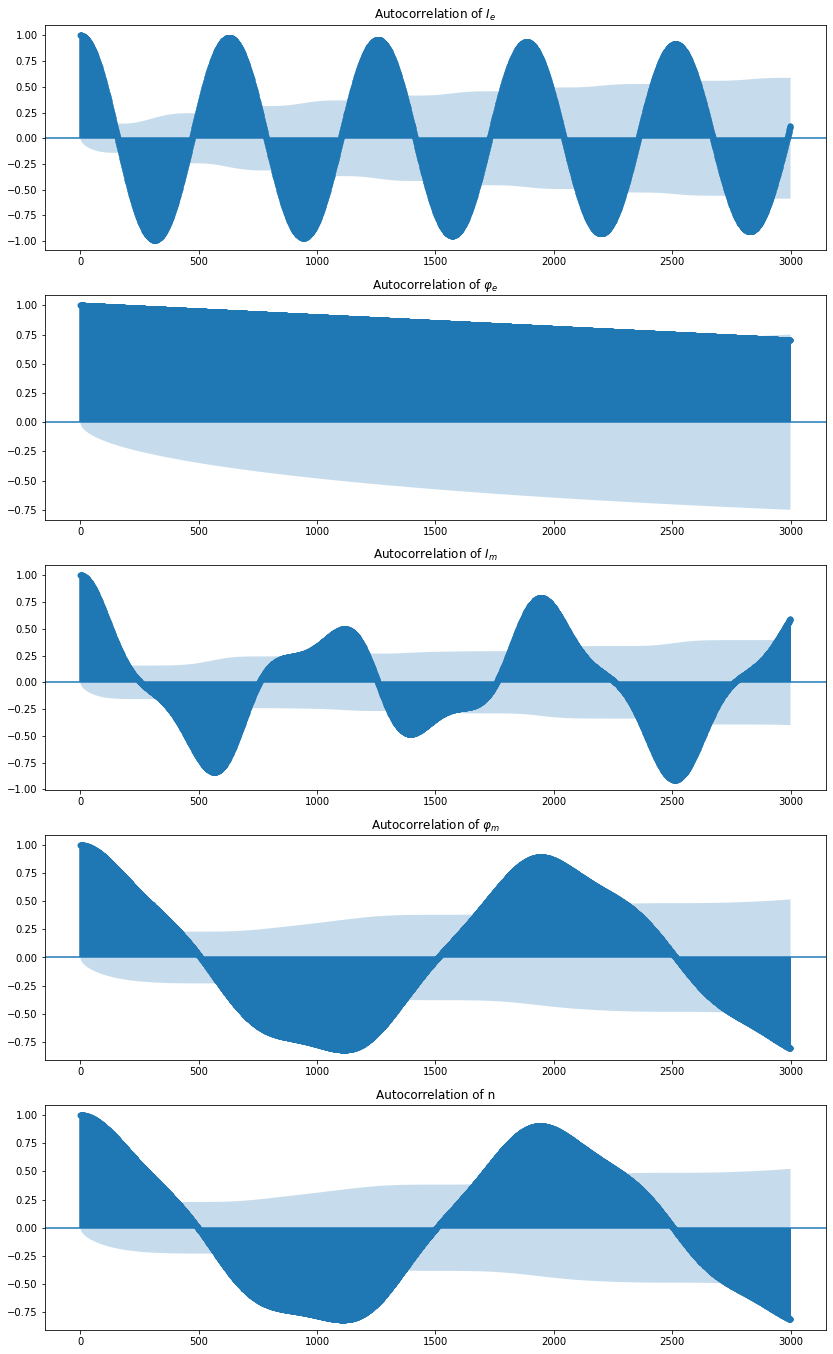

In [14]:
fig, axs = plt.subplots(5,1, figsize=(14,24))
num_lags = np.arange(0,len(x_test)/10,1)

sgt.plot_acf(x_test[:,0], ax=axs[0], lags=num_lags, title='Autocorrelation of $I_e$')

sgt.plot_acf(x_test[:,1], ax=axs[1], lags=num_lags, title='Autocorrelation of $\u03C6_e$')

sgt.plot_acf(x_test[:,2], ax=axs[2], lags=num_lags, title='Autocorrelation of $I_m$')
        
sgt.plot_acf(x_test[:,3], ax=axs[3], lags=num_lags, title='Autocorrelation of $\u03C6_m$')

sgt.plot_acf(x_test[:,4], ax=axs[4], lags=num_lags, title='Autocorrelation of n')


plt.show()